In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [3]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [4]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

In [5]:
list_train_probs = []
list_train_probs.append(pd.read_pickle('train_probs_catboost.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_xgb.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm_cf.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_rnn.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_randomforrest.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_etc.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_gbc.pkl'))
train = pd.concat(list_train_probs, axis=1)
train.columns = ['probs_catboost','probs_lightgbm','probs_xgb','probs_lightgbm_cf','probs_rnn','probs_randomforrest','probs_etc','probs_gbc']
train

,probs_catboost,probs_lightgbm,probs_xgb,probs_lightgbm_cf,probs_rnn,probs_randomforrest,probs_etc,probs_gbc
key_value,,,,,,,,
0,0.075559,0.083673,0.075589,0.058853,0.120824,0.091,0.129,0.072149
1,0.161749,0.133572,0.162079,0.120991,0.081559,0.120,0.095,0.067507
2,0.039483,0.039735,0.032988,0.032979,0.079770,0.078,0.071,0.048511
3,0.014844,0.008416,0.011796,0.008240,0.049977,0.032,0.045,0.032224
4,0.988394,0.923350,0.975676,0.960733,0.894703,0.849,0.867,0.928432
...,...,...,...,...,...,...,...,...
358482,0.057822,0.049744,0.061179,0.028396,0.076204,0.051,0.030,0.057319
358483,0.080988,0.069483,0.074895,0.075432,0.093436,0.229,0.076,0.099574
358484,0.323118,0.318980,0.275796,0.279125,0.339166,0.258,0.235,0.324530


In [6]:
list_test_probs = []
list_test_probs.append(pd.read_pickle('test_probs_catboost.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_xgb.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm_cf.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_rnn.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_randomforrest.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_etc.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_gbc.pkl'))
test = pd.concat(list_test_probs, axis=1)
test.columns = ['probs_catboost','probs_lightgbm','probs_xgb','probs_lightgbm_cf','probs_rnn','probs_randomforrest','probs_etc','probs_gbc']
test

,probs_catboost,probs_lightgbm,probs_xgb,probs_lightgbm_cf,probs_rnn,probs_randomforrest,probs_etc,probs_gbc
key_value,,,,,,,,
0,0.003800,0.003408,0.004199,0.004778,0.005558,0.0114,0.0196,0.012302
1,0.173367,0.099485,0.064322,0.109926,0.114443,0.2028,0.1226,0.130250
2,0.034206,0.023485,0.037000,0.026376,0.052527,0.0694,0.1174,0.059041
3,0.439349,0.389429,0.420873,0.468930,0.327141,0.4180,0.4874,0.354711
4,0.212322,0.152717,0.179810,0.173116,0.303175,0.2006,0.1534,0.239575
...,...,...,...,...,...,...,...,...
396661,0.067477,0.095350,0.108038,0.050244,0.028805,0.0614,0.0576,0.016040
396662,0.160853,0.188772,0.155656,0.229417,0.209601,0.1756,0.1722,0.185711
396663,0.291086,0.252339,0.245086,0.266309,0.326250,0.2162,0.1980,0.318277


In [7]:
train.corr()

,probs_catboost,probs_lightgbm,probs_xgb,probs_lightgbm_cf,probs_rnn,probs_randomforrest,probs_etc,probs_gbc
probs_catboost,1.000000,0.973906,0.977462,0.965638,0.934337,0.928176,0.921828,0.951930
probs_lightgbm,0.973906,1.000000,0.986223,0.979459,0.938230,0.932726,0.926764,0.956257
probs_xgb,0.977462,0.986223,1.000000,0.976337,0.943242,0.936275,0.930014,0.960294
probs_lightgbm_cf,0.965638,0.979459,0.976337,1.000000,0.937552,0.932756,0.928296,0.956278
probs_rnn,0.934337,0.938230,0.943242,0.937552,1.000000,0.933519,0.932480,0.963285
probs_randomforrest,0.928176,0.932726,0.936275,0.932756,0.933519,1.000000,0.977921,0.948814
probs_etc,0.921828,0.926764,0.930014,0.928296,0.932480,0.977921,1.000000,0.942523
probs_gbc,0.951930,0.956257,0.960294,0.956278,0.963285,0.948814,0.942523,1.000000


In [15]:
keep_columns = ['probs_catboost','probs_lightgbm','probs_xgb','probs_lightgbm_cf']
train = train[keep_columns]
test = test[keep_columns]
train.shape, test.shape

((358487, 4), (396666, 4))

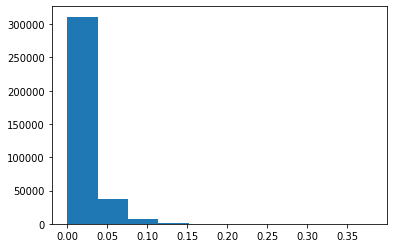

In [16]:
plt.hist(np.std(train.values, axis=1));

### Entrenando el modelo final

In [17]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
print(estimator)
### aplicar cross_validate y learning_rate 
# cross_validate_learning_rate(estimator, train, y_train, scoring='roc_auc')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


train_scores: 0.8516560661255929
test_scores: 0.8516182369609542


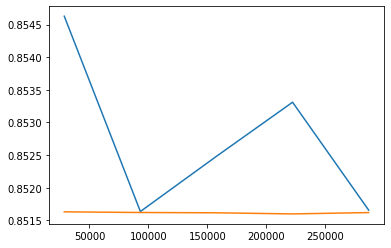

In [18]:
cross_validate_learning_rate(estimator, train, y_train.target, scoring='roc_auc')

In [19]:
test_stacking = pd.Series(estimator.predict_proba(test)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.045153
1         0.085063
2         0.052815
3         0.446536
4         0.127643
            ...   
396661    0.073739
396662    0.142052
396663    0.209183
396664    0.056233
396665    0.063686
Name: target, Length: 396666, dtype: float64

In [20]:
test_stacking.to_csv("../results/stacking_4models_only_0.85161.csv")

In [21]:
!kaggle competitions submit -c interbank20 -f ../results/stacking_4models_only_0.85161.csv -m "test"

Successfully submitted to Datathon Internacional Interbank 2020



  0%|          | 0.00/10.4M [00:00<?, ?B/s]
  0%|          | 8.00k/10.4M [00:00<13:36, 13.4kB/s]
  2%|1         | 208k/10.4M [00:01<01:18, 137kB/s]  
  4%|3         | 416k/10.4M [00:01<00:34, 304kB/s]
  5%|4         | 512k/10.4M [00:02<00:43, 242kB/s]
  5%|5         | 576k/10.4M [00:02<00:45, 228kB/s]
  6%|5         | 624k/10.4M [00:03<00:48, 212kB/s]
  6%|6         | 664k/10.4M [00:03<00:49, 207kB/s]
  7%|6         | 696k/10.4M [00:03<00:52, 196kB/s]
  7%|6         | 728k/10.4M [00:03<00:52, 195kB/s]
  7%|7         | 752k/10.4M [00:03<00:53, 189kB/s]
  7%|7         | 776k/10.4M [00:04<00:55, 183kB/s]
  7%|7         | 800k/10.4M [00:04<00:55, 182kB/s]
  8%|7         | 824k/10.4M [00:04<00:56, 178kB/s]
  8%|7         | 848k/10.4M [00:04<00:55, 180kB/s]
  8%|8         | 872k/10.4M [00:04<00:59, 169kB/s]
  8%|8         | 896k/10.4M [00:04<00:57, 174kB/s]
  9%|8         | 920k/10.4M [00:04<00:57, 175kB/s]
  9%|8         | 944k/10.4M [00:04<00:56, 176kB/s]
  9%|9         | 968k/10.4M [00:0